# Gem strategy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/gem.csv")
print(df.head())

         Date  BND  EUM  IAU        SPY        QQQ        TLT
0  2002-08-08  0.0  0.0  0.0  90.949997  23.570000  83.699997
1  2002-08-09  0.0  0.0  0.0  91.290001  23.330000  84.879997
2  2002-08-12  0.0  0.0  0.0  90.620003  23.400000  85.400002
3  2002-08-13  0.0  0.0  0.0  88.970001  22.600000  86.449997
4  2002-08-14  0.0  0.0  0.0  92.220001  24.040001  86.779999


In [4]:
REBALANCE_PERIOD = 30 #in days
COMPARISON_TIME_WINDOW = 365 #in days
STARTING_CACHE = 1000

# Remove weekends form the simulation
REBALANCE_PERIOD = int(REBALANCE_PERIOD / 7 * 5)
COMPARISON_TIME_WINDOW = int(COMPARISON_TIME_WINDOW / 7 * 5)

## Buy and hold

In [9]:
BUY_AND_HOLD = "SPY"

cache = STARTING_CACHE
values = []
days = []
assets = {}

assets[BUY_AND_HOLD] = cache / df.iloc[COMPARISON_TIME_WINDOW][BUY_AND_HOLD]
cache = 0

for i in range(COMPARISON_TIME_WINDOW + REBALANCE_PERIOD, len(df.index) - COMPARISON_TIME_WINDOW - REBALANCE_PERIOD, REBALANCE_PERIOD):
    value = assets[BUY_AND_HOLD] * df.iloc[i][BUY_AND_HOLD]
    values.append(value)
    days.append(df.iloc[i]["Date"])

print(values[:5])

[np.float64(1032.0557622551473), np.float64(1045.694416194459), np.float64(1033.7481283488255), np.float64(1092.2847641024555), np.float64(1145.8437229562828)]


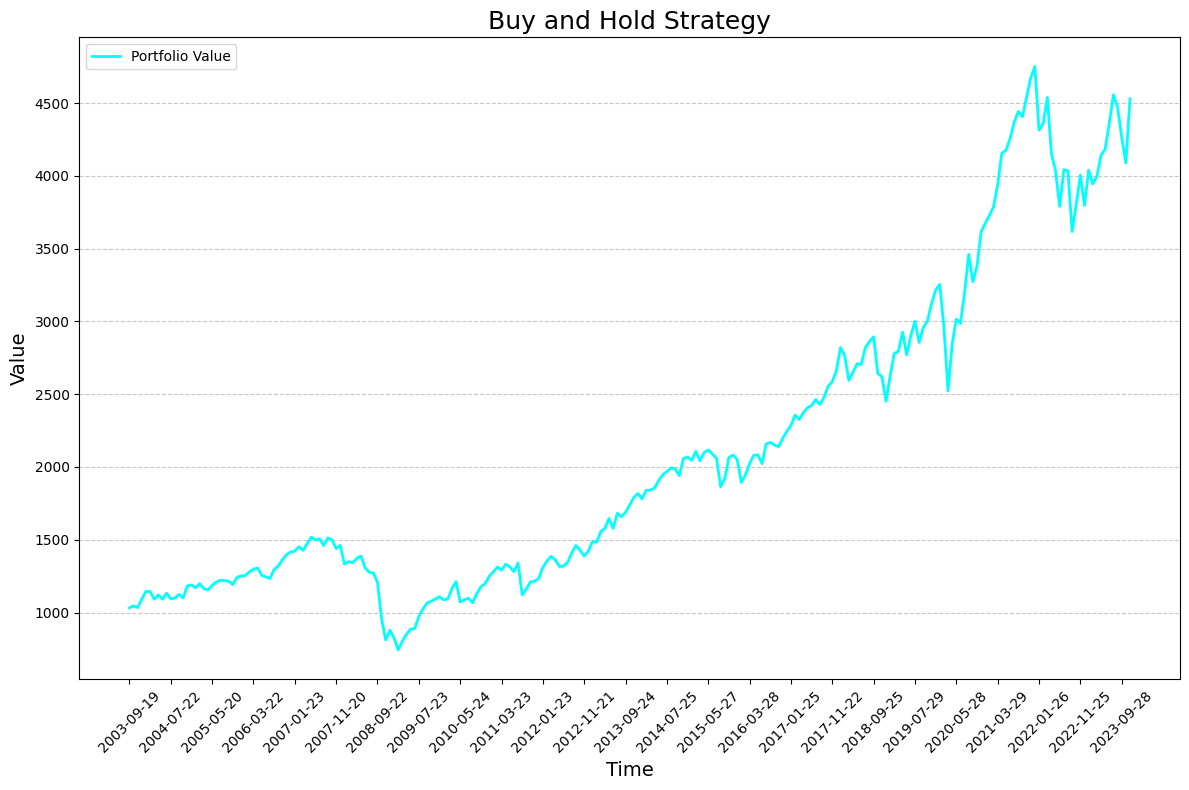

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(days, values, label="Portfolio Value", color="aqua", linewidth=2)
plt.title("Buy and Hold Strategy", fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks(days[::10], rotation=45)
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
